In [54]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F


class MAB(nn.Module):
    def __init__(self, dim_Q, dim_K, dim_V, num_heads, ln=False):
        super(MAB, self).__init__()
        self.dim_V = dim_V
        self.num_heads = num_heads
        self.fc_q = nn.Linear(dim_Q, dim_V)
        self.fc_k = nn.Linear(dim_K, dim_V)
        self.fc_v = nn.Linear(dim_K, dim_V)
        if ln:
            self.ln0 = nn.LayerNorm(dim_V)
            self.ln1 = nn.LayerNorm(dim_V)
        self.fc_o = nn.Linear(dim_V, dim_V)

    def forward(self, Q, K):
        Q = self.fc_q(Q)
        K, V = self.fc_k(K), self.fc_v(K)

        dim_split = self.dim_V // self.num_heads
        Q_ = torch.cat(Q.split(dim_split, 2), 0)
        K_ = torch.cat(K.split(dim_split, 2), 0)
        V_ = torch.cat(V.split(dim_split, 2), 0)

        A = torch.softmax(Q_.bmm(K_.transpose(1, 2)) / math.sqrt(self.dim_V), 2)
        O = torch.cat((Q_ + A.bmm(V_)).split(Q.size(0), 0), 2)
        O = O if getattr(self, "ln0", None) is None else self.ln0(O)
        O = O + F.relu(self.fc_o(O))
        O = O if getattr(self, "ln1", None) is None else self.ln1(O)
        return O


class SAB(nn.Module):
    def __init__(self, dim_in, dim_out, num_heads, ln=False):
        super(SAB, self).__init__()
        self.mab = MAB(dim_in, dim_in, dim_out, num_heads, ln=ln)

    def forward(self, X):
        return self.mab(X, X)


class ISAB(nn.Module):
    def __init__(self, dim_in, dim_out, num_heads, num_inds, ln=False):
        super(ISAB, self).__init__()
        self.I = nn.Parameter(torch.Tensor(1, num_inds, dim_out))
        nn.init.xavier_uniform_(self.I)
        self.mab0 = MAB(dim_out, dim_in, dim_out, num_heads, ln=ln)
        self.mab1 = MAB(dim_in, dim_out, dim_out, num_heads, ln=ln)

    def forward(self, X):
        H = self.mab0(self.I.repeat(X.size(0), 1, 1), X)
        return self.mab1(X, H)


class PMA(nn.Module):
    def __init__(self, dim, num_heads, num_seeds, ln=False):
        super(PMA, self).__init__()
        self.S = nn.Parameter(torch.Tensor(1, num_seeds, dim))
        nn.init.xavier_uniform_(self.S)
        self.mab = MAB(dim, dim, dim, num_heads, ln=ln)

    def forward(self, X):
        return self.mab(self.S.repeat(X.size(0), 1, 1), X)


class DeepSet(nn.Module):
    def __init__(self, dim_input, num_outputs, dim_output, dim_hidden=128):
        super(DeepSet, self).__init__()
        self.num_outputs = num_outputs
        self.dim_output = dim_output
        self.enc = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden),
        )
        self.dec = nn.Sequential(
            nn.Linear(dim_hidden, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.ReLU(),
            nn.Linear(dim_hidden, num_outputs * dim_output),
        )

    def forward(self, X):
        X = self.enc(X).mean(-2)
        X = self.dec(X).reshape(-1, self.num_outputs, self.dim_output)
        return X

In [27]:
import os
import pickle
import random
import sys
import uuid
from pathlib import Path

import implicit
import lightgbm as lgb
import numpy as np
import pandas as pd
import torch.optim as optim
from scipy.sparse import csr_matrix, random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader, Dataset

# 最大表示列数の指定（ここでは50列を指定）
pd.set_option("display.max_columns", 50)

sys.path.append(os.pardir)
from hydra import compose, initialize

from utils import load_datasets
from utils.embedding import TextEmbedder

with initialize(config_path="../yamls", version_base=None):
    config = compose(config_name="config.yaml")


train_df = pd.read_csv(Path(config.input_path) / "train.csv")
test_df = pd.read_csv(Path(config.input_path) / "test.csv")


all_df = pd.concat([train_df, test_df])
all_df["anime_label"], anime_idx = pd.factorize(all_df["anime_id"])
train_df["anime_label"] = all_df[: len(train_df)]["anime_label"]
test_df["anime_label"] = all_df[len(train_df) :]["anime_label"]

In [32]:
grouped_anime

user_id
0008e10fb39e55447333    [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
001a7aed2546342e2602    [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 5...
003d4b0257cc7849ffe1    [195, 196, 197, 198, 199, 200, 201, 62, 202, 2...
0054e700b5be6e074fb7                       [223, 224, 225, 226, 227, 228]
0059344eed7e8ca0b6c5    [229, 230, 82, 231, 232, 233, 234, 235, 236, 237]
                                              ...                        
fe9c772c995668ea3b75    [435, 900, 0, 240, 229, 1015, 833, 1307, 1167,...
feef23df0d53eec7d697                                      [932, 811, 535]
ff441af085c3522f62ba    [1846, 46, 1060, 240, 1061, 319, 320, 484, 201...
ff5e8e9e3553b90f222a    [1325, 1694, 460, 650, 320, 1222, 66, 732, 204...
ffa6ff8006f8630f3d11    [238, 195, 46, 240, 479, 200, 63, 325, 203, 71...
Name: anime_label, Length: 1794, dtype: object

<Axes: >

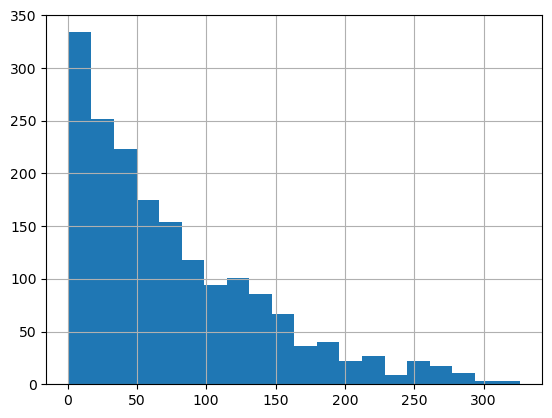

In [47]:
grouped_score.str.len().hist(bins=20)

In [103]:
import random


class AnimeDataset(Dataset):
    def __init__(self, grouped_data, grouped_scores, n_samples=20):
        self.data = list(grouped_data)
        self.scores = list(grouped_scores)
        self.n_samples = n_samples

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        indices = list(range(len(self.data[idx])))

        # n_samples 件を超える場合、ランダムサンプリング
        # n_samples 件未満の場合、重複ありでサンプリング
        if len(indices) >= self.n_samples:
            sampled_indices = random.sample(indices, self.n_samples)
        else:
            sampled_indices = [random.choice(indices) for _ in range(self.n_samples)]

        sampled_data = [self.data[idx][i] for i in sampled_indices]
        sampled_scores = [self.scores[idx][i] for i in sampled_indices]

        return torch.tensor(sampled_data, dtype=torch.long), torch.tensor(sampled_scores, dtype=torch.float32)


class SetTransformer(nn.Module):
    def __init__(self, num_animes, embed_dim, dim_output, num_inds=32, dim_hidden=128, num_heads=4, ln=False):
        super(SetTransformer, self).__init__()

        self.embedding = nn.Embedding(num_animes, embed_dim)

        self.enc = nn.Sequential(
            ISAB(embed_dim, dim_hidden, num_heads, num_inds, ln=ln),
            ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=ln),
            ISAB(dim_hidden, dim_hidden, num_heads, num_inds, ln=ln),
            nn.Linear(dim_hidden, 1),
        )

    def forward(self, X):
        X_embed = self.embedding(X)  # Embed anime_id
        return self.enc(X_embed).squeeze(2)  # Return shape: [batch_size, num_items, dim_output]

In [108]:
train_df

,user_id,anime_id,score,anime_label
0,0008e10fb39e55447333,0669cc0219d468761195,2,0
1,0008e10fb39e55447333,111adb8835b8a1a2cf54,10,1
2,0008e10fb39e55447333,1fc8683c393432a2f9c7,1,2
3,0008e10fb39e55447333,2290175205d55e81b197,8,3
4,0008e10fb39e55447333,28f173b60331d5cabb0d,9,4
...,...,...,...,...
136396,ffa6ff8006f8630f3d11,e9ba5ca32ea7e22e0a55,6,423
136397,ffa6ff8006f8630f3d11,ea2be994d7e36d2a720a,7,1509
136398,ffa6ff8006f8630f3d11,ee3804a55e2b4ad58aad,7,221
136399,ffa6ff8006f8630f3d11,fc143f3fa9979ab1c230,9,193


In [110]:
from sklearn.model_selection import StratifiedGroupKFold

n_samples = 20
batch_size = 10
num_epochs = 2

# ユニークなanime_idの数を取得
num_animes = len(anime_idx)


oof_pred = np.zeros(train_df.shape[0])
test_preds = []

test_grouped_anime = test_df.groupby("user_id")["anime_label"].apply(list)


kf = StratifiedGroupKFold(n_splits=config.nn.num_folds, shuffle=True, random_state=config.seed)
for fold, (train_index, valid_index) in enumerate(kf.split(train_df, train_df["score"], train_df["user_id"])):
    # user_idごとにanime_idのリストと平均スコアを取得
    train_grouped_anime = train_df.iloc[train_index].groupby("user_id")["anime_label"].apply(list)
    train_grouped_score = train_df.iloc[train_index].groupby("user_id")["score"].apply(list)
    valid_grouped_anime = train_df.iloc[valid_index].groupby("user_id")["anime_label"].apply(list)
    valid_grouped_score = train_df.iloc[valid_index].groupby("user_id")["score"].apply(list)

    train_dataset = AnimeDataset(train_grouped_anime, train_grouped_score, n_samples)
    valid_dataset = AnimeDataset(valid_grouped_anime, valid_grouped_score, n_samples)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

    # ハイパーパラメータ
    embed_dim = 64
    num_outputs = 5
    dim_output = n_samples  # 1次元の出力（ユーザーの平均スコア）

    model = SetTransformer(
        num_animes=num_animes,
        embed_dim=embed_dim,
        dim_output=dim_output,  # Since we want to predict scores, the dim_output is 1.
    )

    criterion = nn.MSELoss()  # Using MSE as the loss for RMSE
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model.train()
    for epoch in range(num_epochs):  # ここのエポック数もサンプルです
        for data, scores in train_loader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = torch.sqrt(criterion(outputs, scores))
            loss.backward()
            optimizer.step()

    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for idx in range(len(test_dataset)):
            data, scores = test_dataset[idx]
            anime_ids_chunks = [
                data[i : i + n_samples] for i in range(0, len(data), n_samples)
            ]  # indexをシャッフルして n 個ずつに分割　を繰り返せば良い
            aggregated_predictions = []

            for chunk in anime_ids_chunks:
                aggregated_predictions.append(model(chunk))

            aggregated_predictions = torch.cat(aggregated_predictions, dim=1)
            predictions.append(aggregated_predictions.mean(0).numpy())
            actuals.append(scores.numpy())

KeyboardInterrupt: 

In [106]:
for ids, targets in dataloader:
    print(ids.shape)
    print(model(ids).shape)
    print(model(ids))
    break

torch.Size([3, 20])
torch.Size([3, 20])
tensor([[-0.2884,  0.1009,  0.0554,  0.1912, -0.1325, -0.2546, -0.0808,  0.1129,
         -0.2008, -0.2096, -0.1470, -0.1110, -0.0622, -0.0298, -0.2887,  0.0467,
          0.0543, -0.1533, -0.0927, -0.2651],
        [-0.1442, -0.0322, -0.2503, -0.0396, -0.1201, -0.1345, -0.2368, -0.1042,
         -0.0758, -0.1728, -0.2047, -0.0793, -0.1244,  0.0835, -0.1532, -0.1129,
          0.0184, -0.0516, -0.1734,  0.1022],
        [-0.0266,  0.1416, -0.3700,  0.0224,  0.0374, -0.1015, -0.0806,  0.0909,
         -0.0833, -0.2956,  0.0547, -0.0016, -0.1601, -0.0012,  0.0667, -0.1092,
         -0.0600, -0.1498, -0.1902, -0.1933]], grad_fn=<SqueezeBackward1>)


In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    for anime_ids, scores in dataloader:
        output = model(anime_ids)